In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 17.6 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np, cv2, pytesseract

In [ ]:
car_detection_model = YOLO('yolov8n.pt')
lp_model = '/content/license-plate-finetune-v1m.pt'
seatbelt_model = YOLO('/content/seatbelt_best.pt')

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np, cv2, pytesseract
import cv2
import easyocr

reader = easyocr.Reader(['en'])

car_detection_model = YOLO('yolov8n.pt')
lp_model = YOLO('license-plate-finetune-v1m.pt')
#seatbelt_model = YOLO('best.pt')

def detect_cars(image_path: Path | str):
    car_results = car_detection_model.predict(source=image_path, classes=[2], conf=0.4)
    output = []
    orig = car_results[0].orig_img
    for box in car_results[0].boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        output.append(orig[y1:y2, x1:x2])
    return output

def detect_license_plate(car_image: np.ndarray):
    results = lp_model.predict(car_image, conf=0.3)
    plates = []
    for box in results[0].boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        plates.append(car_image[y1:y2, x1:x2])
    return plates

def read_license_plate(plate_img):
    plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB)
    result = reader.readtext(plate_img)
    text = ''.join([res[1] for res in result])
    return text


def detect_seatbelt(car_image: np.ndarray):
    results = seatbelt_model.predict(car_image, conf=0.1)

    detections = []
    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            class_name = seatbelt_model.names[cls_id]
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            detections.append({
                'class': class_name,
                'box': [int(x1), int(y1), int(x2), int(y2)]
            })
    return detections

def full_pipeline(image_path: str):
    cars = detect_cars(image_path)
    print(len(cars))
    output = []
    for i, car in enumerate(cars):
        plates = detect_license_plate(car)
        texts = [read_license_plate(p) for p in plates]
        seatbelt = detect_seatbelt(car)
        output.append({'car_id': i, 'license_plate': texts, 'seatbelt': seatbelt})
    print(output)
    return output

In [ ]:
cars = "/content/cars.jpg"

In [ ]:
c = full_pipeline(cars)


image 1/1 /content/cars.jpg: 640x480 21 cars, 272.2ms
Speed: 10.3ms preprocess, 272.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)
21

0: 544x640 2 License_Plates, 1742.4ms
Speed: 7.5ms preprocess, 1742.4ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 (no detections), 179.8ms
Speed: 3.7ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 1 License_Plate, 1065.4ms
Speed: 4.0ms preprocess, 1065.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 164.7ms
Speed: 4.0ms preprocess, 164.7ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 1 License_Plate, 1175.8ms
Speed: 4.7ms preprocess, 1175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 (no detections), 193.5ms
Speed: 4.2ms preprocess, 193.5ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 1 License_Plat

In [ ]:
c1 = detect_cars(cars)


image 1/1 /content/cars.jpg: 640x480 21 cars, 173.9ms
Speed: 4.3ms preprocess, 173.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
c2 = []
for car_img in c1:
    plates = detect_license_plate(car_img)
    c2.extend(plates)


0: 544x640 2 License_Plates, 1114.1ms
Speed: 4.5ms preprocess, 1114.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 1 License_Plate, 1039.2ms
Speed: 4.3ms preprocess, 1039.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 1 License_Plate, 1146.0ms
Speed: 4.1ms preprocess, 1146.0ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 1 License_Plate, 1487.8ms
Speed: 4.2ms preprocess, 1487.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 License_Plate, 1529.8ms
Speed: 4.7ms preprocess, 1529.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 1 License_Plate, 1239.3ms
Speed: 4.8ms preprocess, 1239.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)

0: 576x640 1 License_Plate, 1175.0ms
Speed: 5.1ms preprocess, 1175.0ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)

0: 608x640 1 License_Plate, 1249.1ms
Sp

In [ ]:
c4 = detect_seatbelt(c1)


0: 640x640 (no detections), 311.2ms
1: 640x640 (no detections), 311.2ms
2: 640x640 (no detections), 311.2ms
3: 640x640 (no detections), 311.2ms
4: 640x640 1 person-noseatbelt, 311.2ms
5: 640x640 (no detections), 311.2ms
6: 640x640 1 person-noseatbelt, 2 person-seatbelts, 311.2ms
7: 640x640 1 person-noseatbelt, 311.2ms
8: 640x640 (no detections), 311.2ms
9: 640x640 (no detections), 311.2ms
10: 640x640 (no detections), 311.2ms
11: 640x640 (no detections), 311.2ms
12: 640x640 1 person-noseatbelt, 311.2ms
13: 640x640 (no detections), 311.2ms
14: 640x640 (no detections), 311.2ms
15: 640x640 1 person-noseatbelt, 311.2ms
16: 640x640 (no detections), 311.2ms
17: 640x640 (no detections), 311.2ms
18: 640x640 (no detections), 311.2ms
19: 640x640 (no detections), 311.2ms
20: 640x640 1 person-seatbelt, 1 seatbelt, 311.2ms
Speed: 6.0ms preprocess, 311.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
len(c3)

22

In [ ]:
len(c2)

22

In [ ]:
len(c1)

21

In [ ]:
print(c4)

[]


Car 1


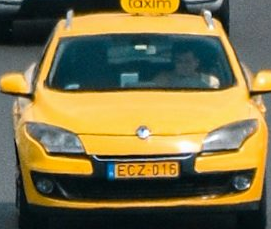

Car 2


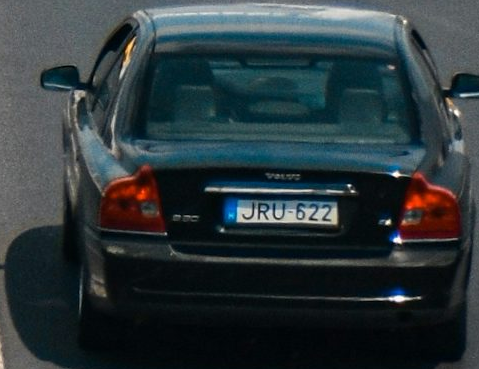

Car 3


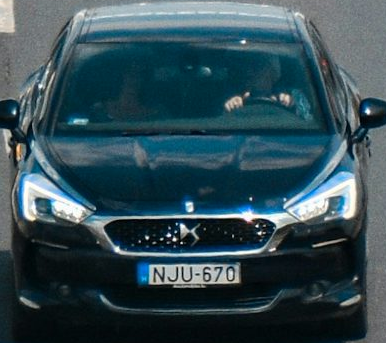

Car 4


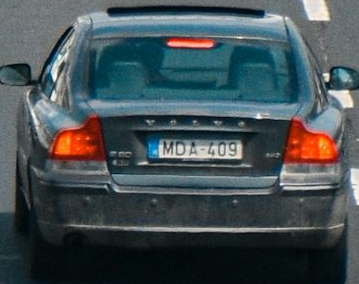

Car 5


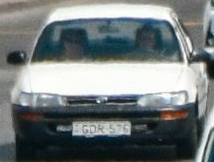

Car 6


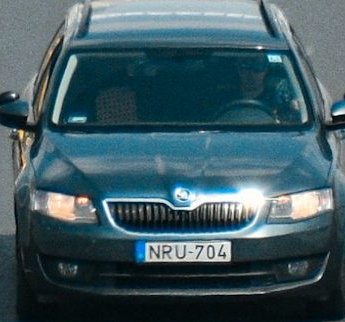

Car 7


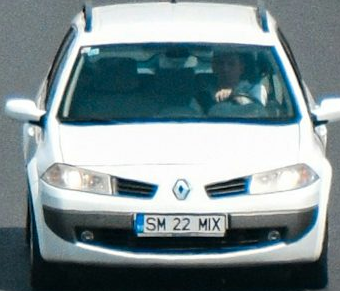

Car 8


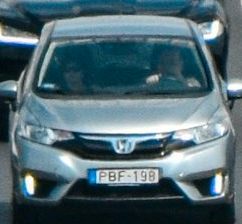

Car 9


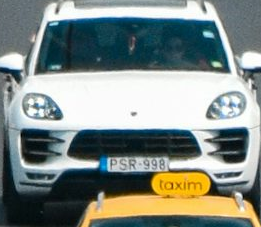

Car 10


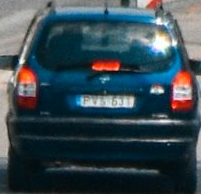

Car 11


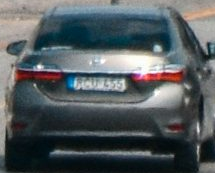

Car 12


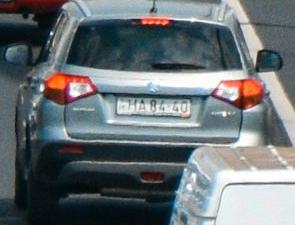

Car 13


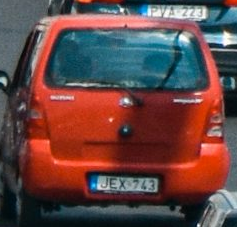

Car 14


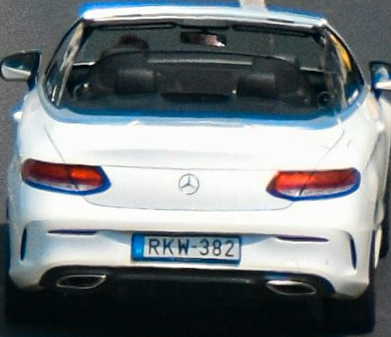

Car 15


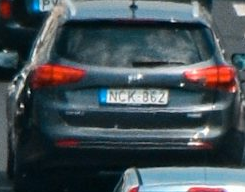

Car 16


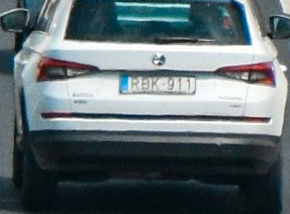

Car 17


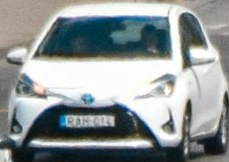

Car 18


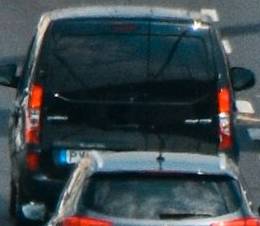

Car 19


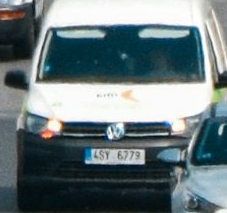

Car 20


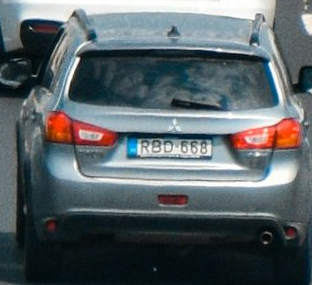

Car 21


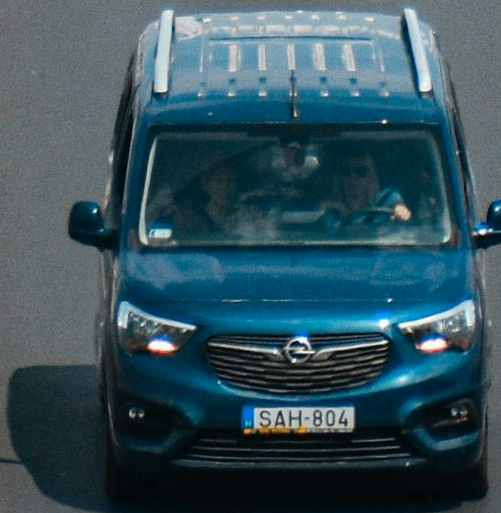

In [ ]:
from google.colab.patches import cv2_imshow

for i, car_img in enumerate(c1):
    print(f"Car {i+1}")
    cv2_imshow(car_img)



Plate 1


Plate 2


Plate 3


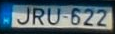

Plate 4


Plate 5


Plate 6


Plate 7


Plate 8


Plate 9


Plate 10


Plate 11


Plate 12


Plate 13


Plate 14


Plate 15


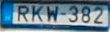

Plate 16


Plate 17


Plate 18


Plate 19


Plate 20


Plate 21


Plate 22


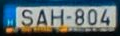

In [ ]:
for i, plate_img in enumerate(c2):
    print(f"Plate {i+1}")
    cv2_imshow(plate_img)


In [ ]:
c3 = []
for plate_img in c2:
    text = read_license_plate(plate_img)
    c3.append(text)

print(c3)

['ECZ Ob', '', 'DRU 622', 'NJU-670', 'MDL-hog', '', 'NRU-704', 'FSH 22 MX', 'PBF-19B', 'PSEAYH', '', '', '', 'Uextd', 'RKH382', '', '', '', '', 'J', 'IRBD 058', 'ISAH  804']
